<a href="https://colab.research.google.com/github/alekriley/alekriley.github.io/blob/master/path_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Path Generation for Testing

In [0]:
#create a path

np.random.seed(10)
vols = [0.15,0.3,0.05,0.5]
returns = [0.03,0.,0.08,0.01]
t = 1000
path = np.zeros(t)
for t in range(1,t):
  #select a vol
  v = np.random.choice(vols)
  r = np.random.choice(returns)
  path[t] = (r-0.5*v**2)/252 + np.random.randn()*v/np.sqrt(252)
path = np.exp(np.cumsum(path))





# Indicators

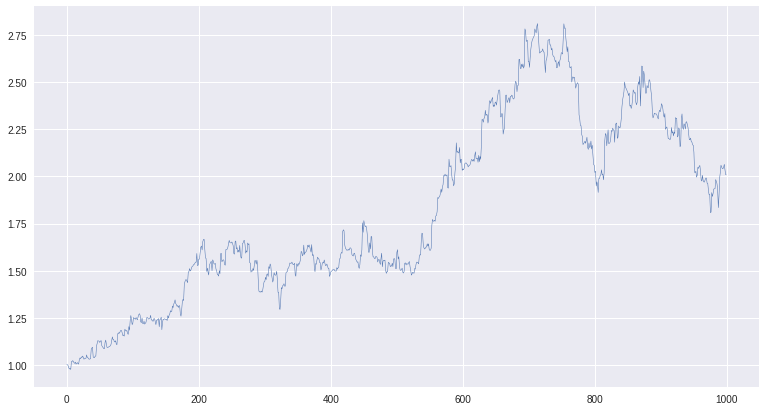

In [3]:
fig = plt.figure(figsize=(13,7))
plt.plot(path,lw=0.5)
plt.show()

In [0]:
def moving_average(path,window_size):
  return [np.mean(path[i-window_size+1:i+1]) for i in range(window_size-1,len(path))]

def rolling_vol(path,window_size):
  r = np.diff(path)/path[:-1]
  return [np.std(r[i-window_size+1:i+1]) for i in range(window_size-1,len(r))]
  
  
                                                              

In [0]:
windows = [13,26,52]
features = np.zeros([t+1,len(windows)*(len(windows)+3)//2])
returns = np.diff(path)/path[:-1]

w = 0
for window in windows:
  features[window:,w] = np.diff(moving_average(path,window))/moving_average(path,window)[:-1]
  w += 1
for window in windows:
  features[window:,w] = rolling_vol(path,window)
  w += 1
for i in range(len(windows)-1):
  for j in range(i+1,len(windows)):
    features[windows[j]-1:,w] = np.array(moving_average(path,windows[j]))/np.array(moving_average(path,windows[i])[windows[j]-windows[i]:])-1





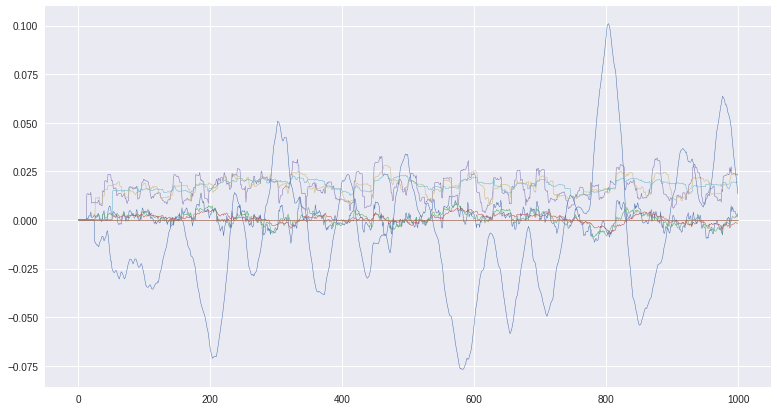

In [10]:
fig = plt.figure(figsize=(13,7))
plt.plot(features,lw=0.5)
plt.show()

In [0]:
class PathGenerator:
  pass

In [0]:
def placeholders(self):
  self.conditions = tf.placeholder(tf.float32,[None,None,None])
  self.samples = tf.placeholder(tf.float32,[None,None,None])
  self.path = tf.placeholder(tf.float32,[None,None])

PathGenerator.__placeholders = classmethod(placeholders)

In [0]:
def encoder(self,cell_size,dropout,n_cells,projection_size):
  X = tf.concat([self.conditions,tf.expand_dims(self.path,-1)],-1)
  batch_size, sequence_length, _ = tf.shape(X)
  with tf.variable_scope('encoder'):
    self.ecell = tf.nn.rnn_cell.MultiRNNCell([
        tf.nn.rnn_cell.ResidualWrapper(
            tf.nn.rnn_cell.DropoutWrapper(
                tf.nn.rnn_cell.GRUCell(cell_size),1.,1-dropout)) for _ in range(n_cells)])
    
    states, _ = tf.nn.dynamic_rnn(self.ecell,X,dtype=tf.float32)
    projection = tf.layers.dense(states,2*projection_size)
    self.encoder_states = self.samples*tf.exp(projection[:,:,projection_size:])+projection[:,:,:projection_size]
    
PathGenerator.__encoder = classmethod(encoder)


In [0]:
def decoder(self,cell_size,dropout,n_cells):
  with tf.variable_scope('decoder'):
    self.dcell = tf.nn.rnn_cell.MultiRNNCell([
                  tf.nn.rnn_cell.ResidualWrapper(
                    tf.nn.rnn_cell.DropoutWrapper(
                      tf.nn.rnn_cell.GRUCell(cell_size),1.,1-dropout)) for _ in range(n_cells)])
    